# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [251]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
#from numba import jit, cuda
%matplotlib inline
np.random.seed(100)

#### Dataset que se va a utilizar para el entrenamiento

In [252]:
DataFrame=pd.read_csv('Jugadores_Característica.csv',low_memory=False)
IDs=DataFrame.ID.tolist()
DataFrame=DataFrame.drop(columns=['Unnamed: 0',"ID"])
datos=DataFrame.to_numpy()

for index,x in enumerate(datos):
    for i in range(datos.shape[1]):
        if "+" in str(x[i]) or "-" in str(x[i]):
            resultado=eval(x[i])
            datos[index][i]=resultado
datos = datos.astype(np.float)

DataFrameDatosPersonales=pd.read_csv('Jugadores_DatosPersonales.csv')
DataFrameDatosPosiciones=pd.read_csv('Jugadores_Posiciones.csv')
#DataFrame.iloc[16955] #sale que tiene 116 de stamina eso es posible???
datos.shape

(17981, 34)

## SOM Setup
#### Variables definidas por el alumno

In [253]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 25 #25*25 =625, tendremos 900 neuronas
periodo = 100000 # las veces que se repite
learning_rate =  0.7 # cuanto se desplaza la neurona
normalizar_datos = True #normalizamos los datos


#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [254]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = datos.shape[1]
num_datos = datos.shape[0]

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa / 2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datos = datos/ datos.max()
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random([lado_mapa,lado_mapa,num_entradas])# lo ponemos directamente 30,30,3

#### Funciones para entrenar/clasificar

In [255]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, Buscar_Error_Topologico):

    Minimo2=0.0
    bmu_idx=[0,0]
    bmu_idx2=[0,0]
    for x in range(m_pesos.shape[0]):
        for x2 in range(m_pesos.shape[1]):
            Dist =np.sqrt(np.sum((m_pesos[x][x2] - patron_entrada) ** 2))
            if (x==0 and x2==0) or Dist<Minimo:
                
                Minimo=Dist

                bmu=m_pesos[x][x2].copy()
 
                bmu_idx[0]=x
                bmu_idx[1]=x2
            elif Minimo2==0.0 or Dist<Minimo2:
                Minimo2=Dist
                bmu_idx2[0]=x #se guarda la antigua neurona que era mas cercana, acabara siendo la 2 neurona 
                bmu_idx2[1]=x2 # mas cerca a la patron de entrada, esto lo acemos para el error topologico
               
    if Buscar_Error_Topologico:
        return bmu_idx2,bmu_idx
    return bmu,bmu_idx

In [256]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""

def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    learning_rate=lr_inicial*(1-(i/ n_iteraciones))
    return learning_rate

In [257]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""

def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    lvecindario=1+vecindario_inicial*(1-(i/ n_iteraciones))
    return lvecindario

In [258]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

In [259]:
# aqui pintaremos el histeriograma 3D


def histograma3D(datos):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    #Creamos como una malla X-Y, se puede pensar como el suelo
    x_data, y_data = np.meshgrid( np.arange(datos.shape[1]), np.arange(datos.shape[0]) )

    '''
    Se necesitasn arrays planos tridimensionales (eso es lo que espera ax.bar3d), por eso hacemos el .flatten()
    x_data=cordenadas eje x
    y_data=cordenadas eje y
    z_data=cordenadas eje z
    '''

    x_data = x_data.T.flatten()
    y_data = y_data.T.flatten()
    z_data = datos.flatten()
 
    colors = plt.cm.jet(z_data/float(datos.max())) # se crea una  matrix Lado*lado ,4 ; el 4 es porque esta en formato rgba
    #ejemplo si el hay 900 neuronas(30*30) , se crea una matriz de [900,4] y depedniedno del valor que tenga el mapa
    # de activacion se le dara un color u otro (en formato rgba): ej: para todos los valors =0, sera el azul, para todos los de 
    # valor 1, sera el verde y así...
    
    ax.bar3d( x_data,y_data,np.zeros(len(z_data)),0.7, 0.7, z_data, color=colors) 
    # Los dos valores numericos, representan el grosor de la barra, el primero respecto al eje x y el otro respecto al z
  
    ax.set_xlabel('Neuronas')
    ax.set_ylabel('Neuronas')
    ax.set_zlabel('Nº de veces activada')
    plt.show()


## SOM Entrenamiento

In [260]:
# Entrena la red con el dataset de entrenamiento
for iteracion in range(periodo):
    aleatorio=np.random.randint(num_datos)
    
    ValoresEscogidos=datos[aleatorio] # como los datos no se van a modificar no hace falta que pongas el .copy()
 
    bmu,bmu_idx=calcular_bmu(ValoresEscogidos,matriz_pesos,False)

    learning_rate_actual=variacion_learning_rate(learning_rate,iteracion,periodo)
    matriz_pesos[bmu_idx[0]][bmu_idx[1]]+=learning_rate_actual*(ValoresEscogidos-bmu)
    
    vecindario_actual=variacion_vecindario(vecindario,iteracion,periodo)
    
    for x in range(matriz_pesos.shape[0]):
        for x2 in range(matriz_pesos.shape[1]):
            Coordenadas_Neurona=np.array([x, x2])
            distancia =np.sqrt(np.sum((bmu_idx - Coordenadas_Neurona) ** 2))
            if distancia<=vecindario_actual:
                amortiguacion=decay(distancia,vecindario_actual)
                matriz_pesos[x][x2]+= amortiguacion*learning_rate_actual*(ValoresEscogidos-matriz_pesos[x][x2])
              
    
    if (iteracion+1)%100==0: 
        print("Iteración: " + str(iteracion+1))

Iteración: 100
Iteración: 200
Iteración: 300
Iteración: 400
Iteración: 500
Iteración: 600
Iteración: 700
Iteración: 800
Iteración: 900
Iteración: 1000
Iteración: 1100
Iteración: 1200
Iteración: 1300
Iteración: 1400
Iteración: 1500
Iteración: 1600
Iteración: 1700
Iteración: 1800
Iteración: 1900
Iteración: 2000
Iteración: 2100
Iteración: 2200
Iteración: 2300
Iteración: 2400
Iteración: 2500
Iteración: 2600
Iteración: 2700
Iteración: 2800
Iteración: 2900
Iteración: 3000
Iteración: 3100
Iteración: 3200
Iteración: 3300
Iteración: 3400
Iteración: 3500
Iteración: 3600
Iteración: 3700
Iteración: 3800
Iteración: 3900
Iteración: 4000
Iteración: 4100
Iteración: 4200
Iteración: 4300
Iteración: 4400
Iteración: 4500
Iteración: 4600
Iteración: 4700
Iteración: 4800
Iteración: 4900
Iteración: 5000
Iteración: 5100
Iteración: 5200
Iteración: 5300
Iteración: 5400
Iteración: 5500
Iteración: 5600
Iteración: 5700
Iteración: 5800
Iteración: 5900
Iteración: 6000
Iteración: 6100
Iteración: 6200
Iteración: 6300
I

Iteración: 49000
Iteración: 49100
Iteración: 49200
Iteración: 49300
Iteración: 49400
Iteración: 49500
Iteración: 49600
Iteración: 49700
Iteración: 49800
Iteración: 49900
Iteración: 50000
Iteración: 50100
Iteración: 50200
Iteración: 50300
Iteración: 50400
Iteración: 50500
Iteración: 50600
Iteración: 50700
Iteración: 50800
Iteración: 50900
Iteración: 51000
Iteración: 51100
Iteración: 51200
Iteración: 51300
Iteración: 51400
Iteración: 51500
Iteración: 51600
Iteración: 51700
Iteración: 51800
Iteración: 51900
Iteración: 52000
Iteración: 52100
Iteración: 52200
Iteración: 52300
Iteración: 52400
Iteración: 52500
Iteración: 52600
Iteración: 52700
Iteración: 52800
Iteración: 52900
Iteración: 53000
Iteración: 53100
Iteración: 53200
Iteración: 53300
Iteración: 53400
Iteración: 53500
Iteración: 53600
Iteración: 53700
Iteración: 53800
Iteración: 53900
Iteración: 54000
Iteración: 54100
Iteración: 54200
Iteración: 54300
Iteración: 54400
Iteración: 54500
Iteración: 54600
Iteración: 54700
Iteración: 548

Iteración: 97200
Iteración: 97300
Iteración: 97400
Iteración: 97500
Iteración: 97600
Iteración: 97700
Iteración: 97800
Iteración: 97900
Iteración: 98000
Iteración: 98100
Iteración: 98200
Iteración: 98300
Iteración: 98400
Iteración: 98500
Iteración: 98600
Iteración: 98700
Iteración: 98800
Iteración: 98900
Iteración: 99000
Iteración: 99100
Iteración: 99200
Iteración: 99300
Iteración: 99400
Iteración: 99500
Iteración: 99600
Iteración: 99700
Iteración: 99800
Iteración: 99900
Iteración: 100000


## SOM Clasificación

In [277]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada
def clasificacion(datos,num_datos):
    Mapa_Clasificacion =np.zeros((lado_mapa,lado_mapa),dtype=object) #guarda en cada neurona el último patrón clasificado.
    Mapa_Activacion =np.zeros((lado_mapa,lado_mapa)) #guarda el número de patrones reconocido por cada neurona
    Mapa_Distancias =np.zeros((lado_mapa,lado_mapa)) #guarda la distancia media de todos los patrones de la clase con su vector de pesos


    Distancia_Media=0.0
    Error_Topologico=0.0
    capas=0
    for iteracion in range(num_datos):
        ValoresEscogidos=datos[iteracion]
        bmu_idx2,bmu_idx=calcular_bmu(ValoresEscogidos,matriz_pesos,True) 
        #########################################
        #distancia media (Error de Cuantificación)
        #########################################
        distancia =np.sqrt(np.sum((matriz_pesos[bmu_idx[0]][bmu_idx[1]] - ValoresEscogidos) ** 2))
        Distancia_Media+=abs(distancia)

        #########################################
        #Error topológico
        #########################################    
        Segunda_BMU=np.array([bmu_idx2[0], bmu_idx2[1]]) # lo tranfromamos en un numpy array, para poder restar
        Distancia_Neuronas_Adyacentes= np.sqrt(np.sum((bmu_idx - Segunda_BMU) ** 2))
        if Distancia_Neuronas_Adyacentes>1.5:#las que esta encima y a los lados su distancia es 1, las que estan en diagonal
            Error_Topologico+=1   #su distancia es de 1.41, por eso ponemos > 1.5 para que nos coga todas menos esas


        ###############MAPAS############
        NombreJugador=DataFrameDatosPersonales.loc[DataFrameDatosPersonales['ID'] == IDs[iteracion]].Name.tolist()[0]
        if Mapa_Activacion[bmu_idx[0]][bmu_idx[1]] >0: #si ya hay un valor en este neurona hacemos la media, entre el valor antiguo y nuevo
            Mapa_Distancias[bmu_idx[0]][bmu_idx[1]] = (Mapa_Distancias[bmu_idx[0]][bmu_idx[1]] + distancia) /2
            Mapa_Clasificacion[bmu_idx[0]][bmu_idx[1]]+=[NombreJugador]
        else:
            capas+=1
            Mapa_Distancias[bmu_idx[0]][bmu_idx[1]]=distancia
            Mapa_Clasificacion[bmu_idx[0]][bmu_idx[1]]=[NombreJugador]

        Mapa_Activacion[bmu_idx[0]][bmu_idx[1]]+=1 #indicamos que ha esta neurona ha sido reconocida por el patron

    Distancia_Media/=num_datos
    Error_Topologico/=num_datos
    print("Error de Cuantificación: "+ str(Distancia_Media))
    print("Error Topológico: "+ str(Error_Topologico))
    print("Capas: "+ str(capas))
    print("\nMapa de Clasificación: ")
    print(Mapa_Clasificacion)
    print("Mapa de Activación: ")
    histograma3D(Mapa_Activacion)
    print("\n\nMapa de Distancias:\n\n"+ str(Mapa_Distancias))
    return Mapa_Clasificacion,Mapa_Activacion

Error de Cuantificación: 0.299254468581205
Error Topológico: 0.11784661587230966
Capas: 616

Mapa de Clasificación: 
[[list(['N. Pareja', 'S. Ignashevich', 'Fontàs', 'Iván Ramis', 'R. Vlaar', 'S. Denswil', 'Lombán', 'Alcalá', 'Diego Ângelo', 'E. Zukanović', 'C. Bovo', 'V. Forren', 'T. Simons', 'Juninho', 'Nuno André Coelho', 'V. Granat', 'M. Kosanović', 'J. de Wijs', 'J. Callsen-Bracker', 'A. Mangane', 'F. Bellugou', 'O. Alanís', 'C. Henao', 'M. Domizzi', 'D. De fauw', 'Morcillo', 'U. Vitas', 'K. Árnason', 'Borja Fernández', 'V. Dyakov', 'A. Głowacki', 'M. Marić', 'J. van der Linden', 'Steven Vitória', 'G. Bourillon', 'J. Bréchet', 'F. Kippe'])
  list(['Dante', 'N. Lombaerts', 'J. Ďurica', 'A. Berezutskiy', 'A. Yahia', 'P. Da Silva', 'L. Lacroix', 'A. Papadopoulos', 'C. Schulz', 'C. Varrault', 'S. Domínguez', 'E. Valencia', 'C. Nasuti', 'Moreno', 'M. Tacalfred', 'B. Bajić', 'C. Baird'])
  list(['Raúl Navas', 'Raúl Navas', 'Antônio Chiamuloira', 'Eltildo Correia', 'B. Espinosa', 'R. Bis

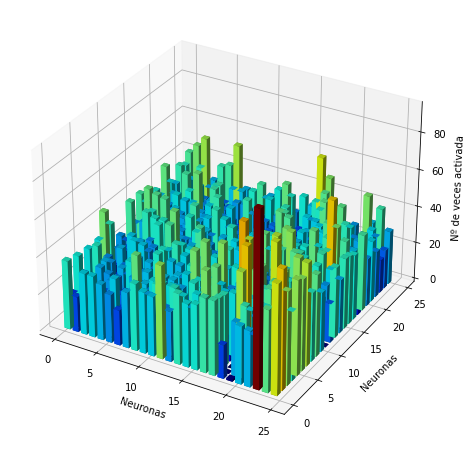



Mapa de Distancias:

[[0.47692708 0.40312084 0.35425911 0.32842127 0.3105907  0.38159597
  0.32184697 0.34081182 0.25116114 0.29788808 0.29021647 0.34226006
  0.31473608 0.2675997  0.2815775  0.36330347 0.29302232 0.35109386
  0.31081141 0.32609713 0.30747932 0.31124548 0.34144411 0.33250007
  0.28204649]
 [0.45566712 0.45362438 0.41485385 0.27758221 0.34920018 0.25886706
  0.27102006 0.31739292 0.35397092 0.34515546 0.34807669 0.28817158
  0.2895858  0.25829978 0.28418307 0.27302679 0.39247314 0.28750944
  0.34162732 0.29172076 0.22363666 0.26344518 0.26636103 0.28238577
  0.2902289 ]
 [0.31155881 0.33204128 0.41898974 0.31741436 0.31432807 0.29557222
  0.24534211 0.29160867 0.23471371 0.33905431 0.33434707 0.28810352
  0.29822302 0.2572873  0.27640899 0.25955366 0.27023884 0.31912567
  0.31019184 0.36487856 0.26560492 0.29358233 0.25249695 0.22633683
  0.337301  ]
 [0.29268117 0.41873373 0.3411908  0.32799227 0.40154642 0.25984118
  0.27109078 0.27171167 0.31936786 0.34682329 0.302

In [278]:
Mapa_Clasificacion,Mapa_Activacion=clasificacion(datos,num_datos)

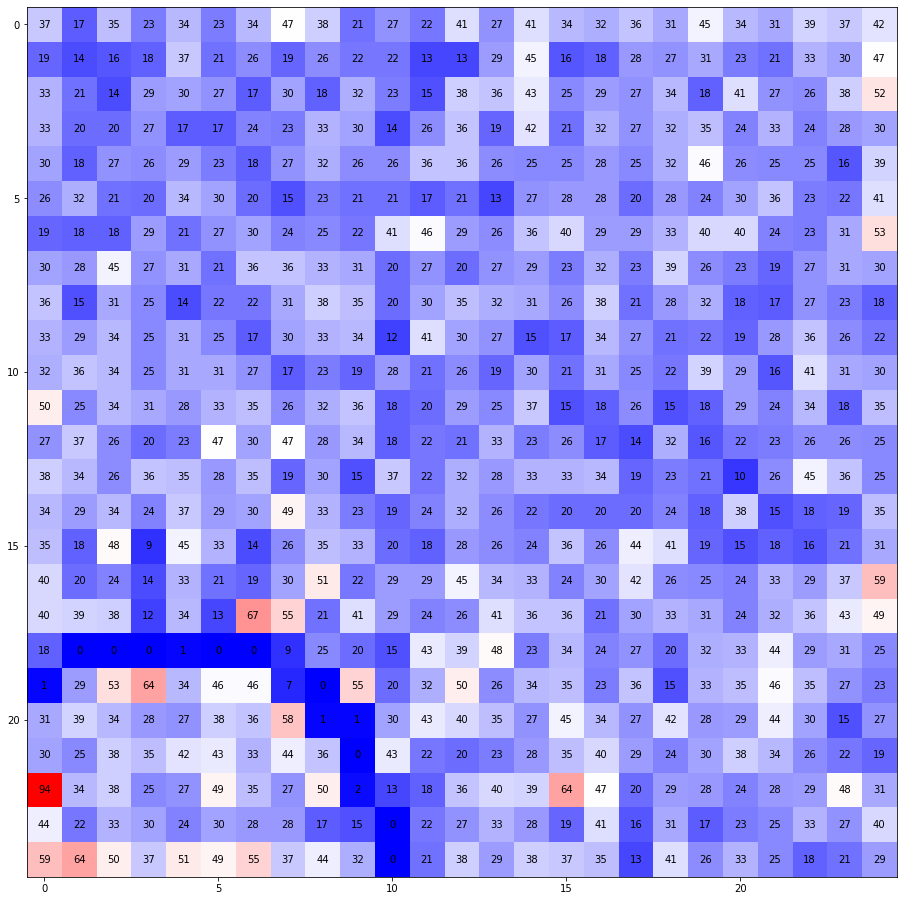

In [294]:
plt.figure(figsize=(18,16))
plt.imshow(Mapa_Activacion, cmap='bwr', interpolation='nearest')
for i in range(lado_mapa):
    for j in range(lado_mapa):
            text = plt.text(j, i, int(Mapa_Activacion[i][j]),ha="center", va="center", color="black")
plt.show()

## SOM Prueba

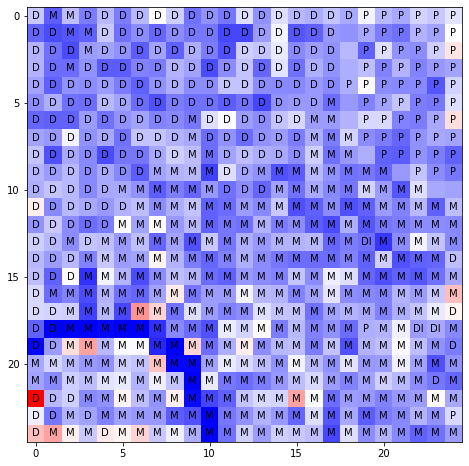

In [295]:
Posiciones_Gugadores_Portero=['GK']
Posiciones_Gugadores_Defensa=['SW','LB','LCB','CB','RCB','RB','LWB','RWB']
Posiciones_Gugadores_Medio=['LDM','CDM','RDM','LM','LCM','CM','RCM','RM','LAM','CAM','RAM']
Posiciones_Gugadores_Delanteros=['LW','LS','CS','RS','RW']
plt.figure(figsize=(10,8))
plt.imshow(Mapa_Activacion, cmap='bwr', interpolation='nearest')
for x in range(lado_mapa):
    for y in range(lado_mapa):
        ConatdosPosiciones=np.array([0,0,0,0])
        if Mapa_Activacion[x][y]!=0:
            listaID=DataFrameDatosPersonales.loc[DataFrameDatosPersonales['Name'].isin(Mapa_Clasificacion[x][y])].ID.tolist()
            sad=DataFrameDatosPosiciones.loc[DataFrameDatosPosiciones['ID'].isin(listaID)]
            asa=sad['Preferred Positions']
            for i in asa:
                i=i.split()
                for PosicionSelect in i:
                    if PosicionSelect in Posiciones_Gugadores_Portero:
                        ConatdosPosiciones[0]+=1
                    elif PosicionSelect in Posiciones_Gugadores_Defensa:
                        ConatdosPosiciones[1]+=1
                    elif PosicionSelect in Posiciones_Gugadores_Medio:
                        ConatdosPosiciones[2]+=1
                    elif PosicionSelect in Posiciones_Gugadores_Delanteros:
                        ConatdosPosiciones[3]+=1  
                        
            Index_Max_Value=np.where(ConatdosPosiciones == np.max(ConatdosPosiciones))[0][0]
            posicionAct=""
            if Index_Max_Value==0:        
                posicionAct="P"
            elif Index_Max_Value==1:
                posicionAct="D"
            elif Index_Max_Value==2:
                posicionAct="M"
            else:
                posicionAct="Dl"

            text = plt.text(x, y, posicionAct,ha="center", va="center", color="black")
        #print(ConatdosPosiciones)
plt.show()


In [285]:

ConatdosPosiciones=[2,2]
np.where(ConatdosPosiciones == np.max(ConatdosPosiciones))[0][0]

0